# Generating Scaling Relations with XGA

This tutorial will explain how to generate XGA scaling relations objects, and go through some of their key useful features. Generating scaling relations that map difficult-to-measure parameters onto values that are easier to determine is very common in cluster science, with mass-temperature, luminosity-temperature, and luminosity-richness relations being just a few that spring to mind.

As such I created this class of product, ScalingRelation, as well as several independent fitting method to generate them from arbitrary data. This part of XGA can almost be viewed as a submodule within the main module, as you do not have to use the source and sample structure to generate relations, the data can be supplied from an external source, and the fitting process will work exactly the same.

In [1]:
import pandas as pd
from astropy.units import Quantity, pix
from astropy.cosmology import Planck15
import numpy as np

from xga.samples.extended import ClusterSample
from xga.sas import evselect_spectrum, emosaic
from xga.xspec import single_temp_apec
from xga.models.misc import power_law
from xga.relations.fit import scaling_relation_lira, scaling_relation_odr
from xga.relations.clusters import LT, Lλ, MT
from xga.products.relation import ScalingRelation

## Relation quality disclaimer

All of the relations we generate here are for demonstration purposes only, they **should not** be used for any real scientific purposes.

## Defining our sample

I am again using clusters from the XCS-SDSS sample, they will be used to demonstrate the fitting and visualisation of scaling relations from an XGA ClusterSample object. I have read in their information from a file as I did not want to include a large table of irrelevant information in one of the cells of this tutorial. This time I will be using fourty randomly chosen clusters rather than four, as we could not reasonably hope to get a good fit with such a small sample.

In [5]:
sample = pd.read_csv("modified_xcssdss_sample.csv", header="infer").sample(40)

srcs = ClusterSample(sample["RA_xcs"].values, sample["DEC_xcs"].values, sample["z"].values, 
                     sample["name"].values, r500=Quantity(sample["r500"].values, 'arcmin'), 
                     clean_obs=True, clean_obs_reg="r500", load_fits=False, psf_corr=False, 
                     richness=sample['richness'].values, richness_err=sample['richness_err'].values)

## Measuring cluster properties

Just as in our last tutorial 'Spectroscopy with XGA', we're going to generate spectra in the R$_{500}$ region for all the sources, and then fit them with a single temperature absorbed APEC model. This will give us the temperature and luminosity of all the clusters in the sample, which will allow us to build a scaling relation as a demonstration of XGA's capabilities:

In [3]:
# This command generates spectra for all the clusters in our sample, in their R500 regions
srcs = evselect_spectrum(srcs, 'r500')

Preparing evselect spectrum commands:  92%|█████████▎| 37/40 [00:37<00:08,  2.90s/it]/home/dt237/software/anaconda3/envs/XGA/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/dt237/software/anaconda3/envs/XGA/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/dt237/software/anaconda3/envs/XGA/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/dt237/software/anaconda3/envs/XGA/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)

Generating products of type(s) spectrum: 100%|██████████| 64/64 [40:12<00:00, 37.70s/it]  


In [4]:
# And this fits a single temperature APEC model to them
srcs = single_temp_apec(srcs, 'r500')

Running XSPEC Fits: 100%|██████████| 40/40 [02:12<00:00,  3.31s/it]


## A scaling relation from a ClusterSample

I've built convenience functions into the ClusterSample class, which make it very easy to generate certain types of common scaling relation. The only information that the method typically needs is the region for which spectra were generated and parameters measured, though plenty of other information (such as the model used to fit the data) can be supplied. The methods assume that, for a ClusterSample, we would have fit an absorbed APEC model, so that is the default.

Once the method call is complete, an XGA scaling relation product is returned to the user. Note that it is not stored inside the sample object, it goes directly back to the user.

The user is allowed to select the x and y normalisation values that should be used during the fit, and can easily change them from their standard values by passing them into keyword arguments. We have found that, in general, the best results are given when the normalisation is similar to the median value of the dataset.

In [5]:
# Making an Lx-Tx relation
lx_tx_relation = srcs.Lx_Tx('r500')

# Making an Lx-richness relation
lx_λ_relation = srcs.Lx_richness('r500')

<string>:12: RuntimeWarning: invalid value encountered in power


## Viewing scaling relations

Just as with other XGA products, there is a ``view()`` method built into the class, to easily create high quality visualisations of the relation. As we generated these relations ourselves, they also have data point associated with them. That is not the case if the scaling relation comes from literature, whether it is one of the ones built into XGA, or one you have defined yourself.

There are several options that change what the output looks like, but one of the main options is the ability to change the figure size, which can be set using the ``figsize`` keyword argument:

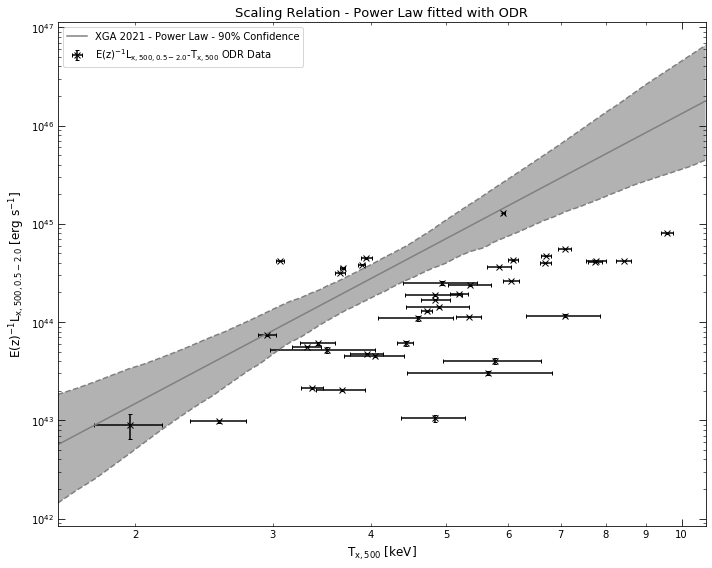

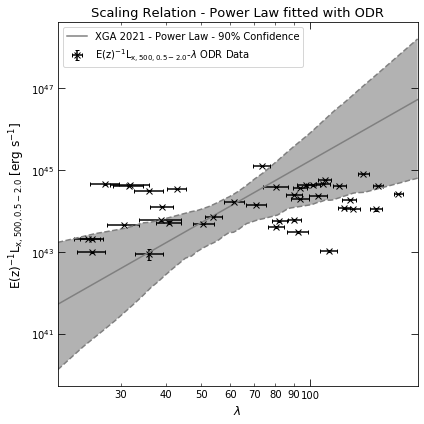

In [6]:
lx_tx_relation.view()

lx_λ_relation.view(figsize=(6, 6))

## Different fitting methods 

I have implemented three different ways to fit these scaling relations, primarily to give the user some choice, though I would **highly recommend** that you use the implementation of the LIRA fitting package for R ([Sereno (2015)](https://academic.oup.com/mnras/article/455/2/2149/1111686)) - LIRA is an extremely capable fitting package, and produces excellent results. The downside is that it requires the installation of some optional external dependencies.

The other methods available are scipy's simple non-linear least squares implementation (curve_fit), and scipy's orthogonal distance regression (ODR) implementation. ODR is the default method for ClusterSample scaling relation methods, as it does not require external dependencies, and seems to work quite well.

I'm going to use a ClusterSample Lx_Tx relation as an example, and show how you can change the fitting method when you call the function - all this does is call the different fitting functions in xga.relations.fit:

R[write to console]: module mix loaded



  |**************************************************| 100%


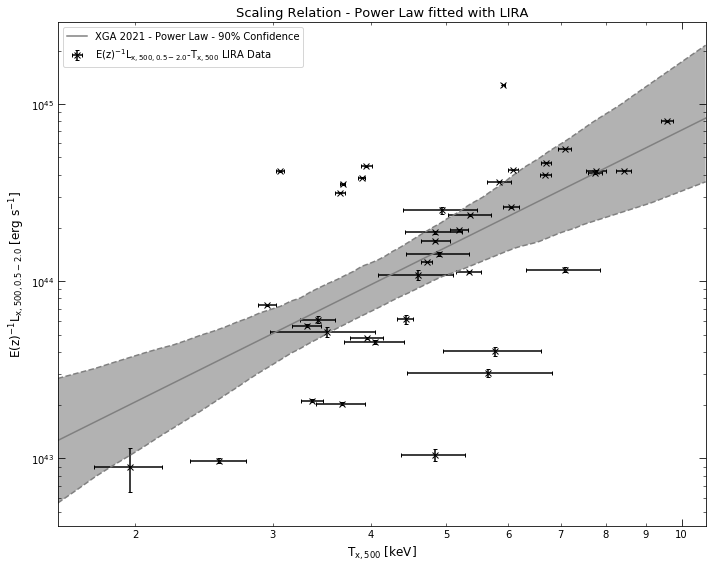

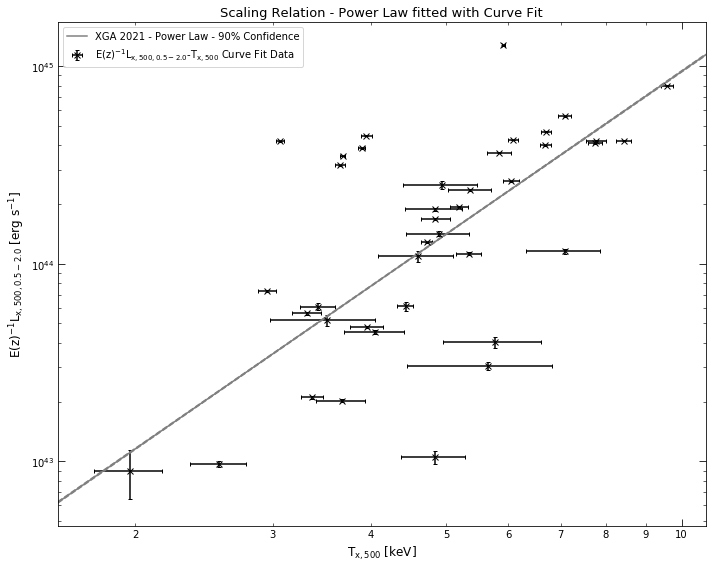

In [7]:
# By setting the fit method to LIRA, we choose to use that instead of the default ODR
lx_tx_relation_lira = srcs.Lx_Tx('r500', fit_method='lira')
# And quickly viewing the relation
lx_tx_relation_lira.view()

# We repeat this process but with scipy's curve_fit
lx_tx_relation_curvefit = srcs.Lx_Tx('r500', fit_method='curve_fit')
lx_tx_relation_curvefit.view()

ScalingRelation objects created using the LIRA fitting method actually have some extra functionality compared to other ScalingRelations. As LIRA is based around the Just Another Gibbs Sampler (JAGS) package, it is an MCMC fitting process, and as such returns parameter chains which it can be useful to visualise.

The output chains are stored in the ScalingRelation on its declaration, and two methods were implemented to generated chain and corner plots:

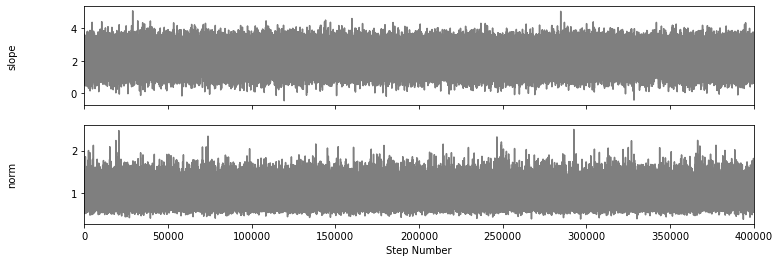

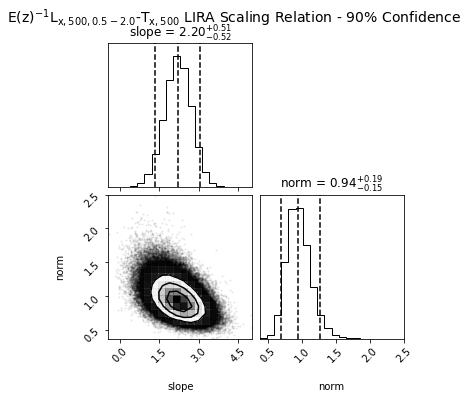

In [8]:
# Here we visualise the parameter chains
lx_tx_relation_lira.view_chains()

# And this shows us a useful corner plot of the parameter space
lx_tx_relation_lira.view_corner()

## ScalingRelation product properties and making predictions

These product objects are quite simple compared to some of the other products in XGA, but still contain a lot of useful information. The information can be broadly split into two groups; administrative information concerning when the relation was generated, who by etc. (especially useful for relations from literature), and that information concerning the actual properties of the relation, units, the normalisations applied etc.

I will demonstrate a few of the properties using a classic relation from literature that has been built into XGA, the ([Arnaud et al. (2005)](https://ui.adsabs.harvard.edu/abs/2005A%26A...441..893A/abstract)) mass-temperature relation. As well as visualising the relation, we can also easily access the fit parameters that were used to define it, using the 'pars' method; the first column contains the values of all fit parameters, and the second column contains the uncertainty.

In [9]:
# Demonstrating the basic adminstrative properties
print(MT.arnaud_m500.year)
print(MT.arnaud_m500.author)
print(MT.arnaud_m500.doi, '\n')

# Viewing the fit parameters that were used to define this scaling relation
print(MT.arnaud_m500.pars)
# We can also easily view the x and y units
print(MT.arnaud_m500.x_unit, MT.arnaud_m500.y_unit)
# And the normalisations
print(MT.arnaud_m500.x_norm, MT.arnaud_m500.y_norm)

2005
Arnaud et al.
10.1051/0004-6361:20052856 

[[1.71 0.09]
 [3.84 0.14]]
keV solMass
5.0 keV 100000000000000.0 solMass


Once we have a scaling relation, we are also able to make predictions from it, using a built in method that takes an Astropy quantity (with the correct units for the x-axis) as an argument. 

The one thing you should remember is that you may need to account for E(z), depending on the relation you have fitted. For instance, the L$_{\rm{x}}$ - T$_{\rm{x}}$ relations produced by XGA automatically multiply by the E(z)$^{-1}$ of each cluster before fitting occurs. As such any values predicted from that relation have an E(z) dependance that must be accounted for to get a physical value:

In [10]:
# Defining an astropy quantity in units of keV, to demonstrate the predict functionality
test_temp = Quantity(6, 'keV')

# Getting a prediction of the cluster mass from that test temperature
MT.arnaud_m500.predict(test_temp)

<Quantity 5.24482685e+14 solMass>

## Viewing multiple scaling relations

As I mentioned briefly in the 'XGA Products' tutorial, ScalingRelation objects have a useful little trick that allows you to easily view different scaling relations on the same axis. As long as two ScalingRelation instances have the same x and y units, you can simply add them together using the Python addition operator. Here I demonstrate this with the L$_{\rm{x}}$ - T$_{\rm{x}}$ relation we measured earlier, and an XCS-SDSS L$_{\rm{x}}$ - T$_{\rm{x}}$ relation imported from XGA:

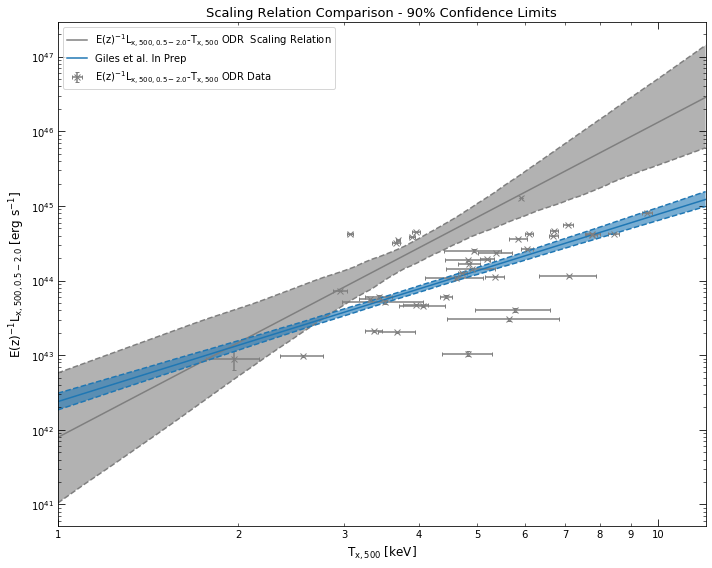

In [11]:
# Adding them together is extremely easy
comb_lt_relation = lx_tx_relation + LT.xcs_sdss_r500_52

# Then we just call .view() like we would normally
comb_lt_relation.view()

## Fitting scaling relations from external data

I tried to think of an interesting dataset that I could generate a scaling relation from as an example, but came up empty, if you can think of an interesting data to use as an example send me an email!

Instead of something interesting, I'm just going to extract some data from our ClusterSample object and show you how to generate a scaling relation manually, using functions imported from xga.relations.fit. We're going to measure a scaling relation that doesn't seem particularly useful, $\lambda$ - T$_{\rm{x}}$:

In [12]:
# Grabbing the temperatures (and temperature errors) from the ClusterSample object
temps = srcs.Tx('r500')
# Printing them on screen 
print(temps, '\n')

# And getting the richness values out as well (they only have a gaussian error)
richnesses = srcs.richness
print(richnesses)

[[7.08243    0.13002101 0.13005287]
 [4.7161     0.0823258  0.08245743]
 [5.36452    0.28213692 0.40368416]
 [6.71121    0.10219178 0.10230914]
 [4.83183    0.40970943 0.41280909]
 [8.42919    0.18324625 0.18334915]
 [5.77845    0.8746071  0.77288657]
 [4.05484    0.34247324 0.36785427]
 [3.06486    0.03359332 0.0338232 ]
 [4.89368    0.44970605 0.45730728]
 [5.84269    0.20509614 0.20562323]
 [5.19119    0.13271175 0.13279313]
 [3.9541     0.1895954  0.19009802]
 [2.95204    0.07918469 0.07944318]
 [3.65808    0.05366061 0.05396875]
 [4.43339    0.10347049 0.10365849]
 [3.89472    0.04077615 0.04093283]
 [7.77419    0.23186019 0.23186347]
 [6.69432    0.1071663  0.10748046]
 [4.83092    0.45555209 0.46017225]
 [3.31708    0.13593715 0.15080525]
 [4.84226    0.20737704 0.20755709]
 [9.5845     0.16951063 0.16944138]
 [4.9339     0.52897228 0.53577265]
 [3.51329    0.42980992 0.65378889]
 [3.67175    0.26013418 0.26353223]
 [3.95184    0.0644903  0.06502766]
 [6.04769    0.13781127 0.13

The scaling relation generation functions expect the data and uncertainties to be passed in separately, so here we're just going to split the data I just retrieved from my ClusterSample object. 

The scaling relation generating methods support data having either two uncertainties (in which case it will understand them as - and + errors), or just the one set of uncertainties. Part of the data preperation step inside of the scaling relation involves calculating an average uncertainty for a value if it is passed in with two uncertainties. This average uncertainty is what is used to fit the data.

In [13]:
# The first column contains the actual temperature values
x_data = temps[:, 0]
# The second and third columns are the uncertainties
x_errs = temps[:, 1:]

# Again the first column contains the richness values
y_data = richnesses[:, 0]
# However this data only has one uncertainty (rather than - and + uncertainties)
y_errs = richnesses[:, 1]

Please make sure you are supplying the x and y data in the correct order, this function needs you to pass the y-data **first**.

Also, when you fit a scaling relation with LIRA, it automatically uses a power-law in logspace as the model to fit with. This is not true of the other fitting methods, and you will need to supply a model for the fit to use; I suggest importing power_law from xga.models.misc and using that. 

There are another couple of differences between the LIRA function and other fitting methods, ODR and Curve Fit both allow you to set start parameters (though you don't have to), and the LIRA fitting function allows you to tell it how many chains should be run, and with how many steps.

When deciding on what to name your x and y axis, please remember not to put units in the name, XGA will add them itself. Also bear in mind that these names will be passed into matplotlib, so some LaTeX syntax will work:

In [14]:
# The x values are temperatures, so selecting an arbitrary normalisation of 4keV
x_norm = Quantity(4, 'keV')
# The y values are richness, which has no unit, but still needs to be in an Astropy quantity
y_norm = Quantity(60, '')

# This uses a LIRA fit to generate the scaling relation
richness_tx_lira = scaling_relation_lira(y_data, y_errs, x_data, x_errs, y_norm, x_norm, 
                                         x_name=r'T$_{\rm{x}}$', y_name=r'$\lambda$')

# This uses ODR to generate a scaling relation, note that I have passed in a model function
richness_tx_odr = scaling_relation_odr(power_law, y_data, y_errs, x_data, x_errs, y_norm, x_norm, 
                                         x_name=r'T$_{\rm{x}}$', y_name=r'$\lambda$')

  |**************************************************| 100%


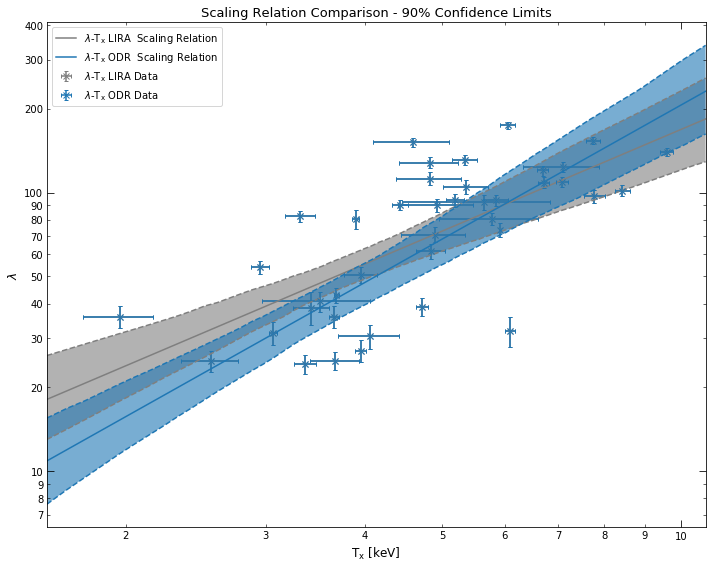

In [15]:
(richness_tx_lira+richness_tx_odr).view()

You can also set a range in which you wish a scaling relation to be valid, when you generate it using one of these fitting functions. For instance I generate the same scaling relation we just created, but decide that it is only valid in the temperature range 2-6keV:

  |**************************************************| 100%


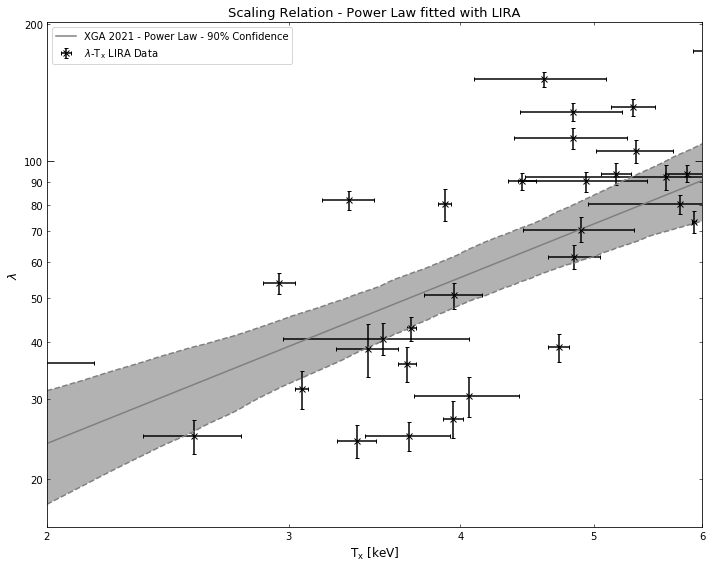

In [16]:
richness_tx_lira_lim = scaling_relation_lira(y_data, y_errs, x_data, x_errs, y_norm, x_norm, 
                                             x_name=r'T$_{\rm{x}}$', y_name=r'$\lambda$', 
                                             x_lims=Quantity([2, 6], 'keV'))
richness_tx_lira_lim.view()

## Defining scaling relations from literature

Here I will demonstrate how you can find a relation in literature, and then implement it in a form usable by XGA. This particular scaling relation is actually already implemented in XGA, and is the Arnaud mass-temperature relation that I used in the demonstrations earlier.

It really is as simple as filling out as many of the ScalingRelation arguments as you need. You should note that 'power_law' in this case is defined in the XGA models package, and is a function used to generate the fit line that is plotted. ScalingRelation will take its x and y units from the normalisations that are passed in on initialisation (here 5keV for the x axis, and 1e+14M$_{\odot}$ for the y-axis).

Please don't include units in the values passed for ``x_name`` and ``y_name``, the ``view()`` method will add its own units, taken from the astropy normalisation quantities:

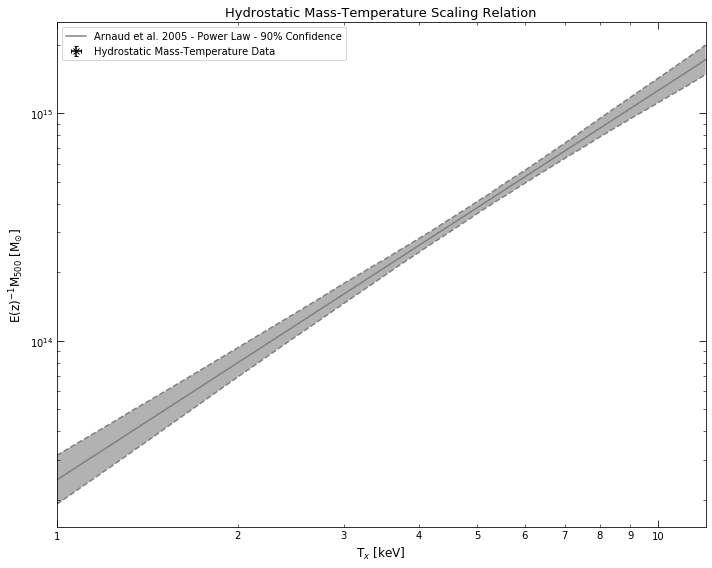

In [17]:
mt_relation = ScalingRelation(np.array([1.71, 3.84]), np.array([0.09, 0.14]), power_law, Quantity(5, 'keV'),
                              Quantity(1e+14, 'solMass'), r"T$_{x}$", "E(z)$^{-1}$M$_{500}$",
                              relation_author='Arnaud et al.', relation_year='2005',
                              relation_doi='10.1051/0004-6361:20052856',
                              relation_name='Hydrostatic Mass-Temperature', x_lims=Quantity([1, 12], 'keV'))
mt_relation.view()